# Team Members: Jaden Phan, Sarah Morrison

Dataset: https://www.kaggle.com/datasets/tunguz/nba-forecasts



# TODO:

* Random down-sample data to reduce computing complexity
* Preliminary binary classification
* Implement Random Forests Algorithm

## Dataset Description
There are two tables provided in this dataset.
1. nba_elo.csv: contains game-by-game "elo" ratings and forecasts back to 1946
2. nba_elo_latest.csv: containts game-by-game "elo" ratings and forecasts for only the latest season.

Both datasets contain the same 24 column attributes. Here are the most important attributes to our study:
* date: yyyy-mm-dd of the game
* season: yyyy of season
* elo1_pre: rating of each team prior to game
* elo_prob: analyst predicted chance of team winning
* elo_post: rating of each team after the result of the game
* score: score of the game for each team for each game

## We want to predict the winner of the games in the 2021 season
To do this, we will be leveraging the data from nba_elo.csv which contains game-by-game data that dates back to 1946. By training the classifier on over 60 years of past games, we hope it will be able to predict the winners of the games in nba_elo_latest.csv, this dataset contains the same game-by-game data but only for the 2020-2021 season.


## Implementation/Technical Merit
* This dataset lacks documentation so we will need to spend some time understanding each attribute as well as deciding units for numerical values.
* There are some attributes with obscure names that we will need to understand as well.
* About 50% of the attributes have a majority of NULL values so we will need to decide how to interpret and handle these missing values.
* Our dataset is about 71,000 instances of data, we will likely need to **randomly sample** or cut down the size of samples in-order to reduce computing time. That being said having such a large dataset allows us to have a large amount of diversity in our data regardless of how we split or sample.

## Potential Impact of Results

Teams:

This could be useful for the teams in terms of strategy and management. It could also help the teams manage their fan engagement and marketing for the upcoming season.

Fans:

For fans, this could be useful for betting. This could also be useful for fans for increased general interest in their team, or rival teams.


# Need to reconsider approach!
Binary classification and binary down sample

In [24]:
# some useful mysklearn package import statements and reloads
import importlib
import pandas as pd
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.mysimplelinearregressor
importlib.reload(mysklearn.mysimplelinearregressor)
import mysklearn.mysimplelinearregressor as linear

train = MyPyTable().load_from_file('input_data/nba_elo.csv')
test = MyPyTable().load_from_file('input_data/nba_elo_latest.csv')



## Check for data leaks
Check training set for any data leaks. Any instances from the 2021 season should not be in the training set because that is the year we are predicting

In [25]:
importlib.reload(mysklearn.mypytable)
train.drop_duplicate_seasons(2021)

## Randomly Down-Sample Dataset
Since our training set nba_elo.csv has over 70,000 instances, we need to down sample in-order to make compute time reasonable

In [26]:
importlib.reload(mysklearn.mypytable)
small_train = train.random_down_sample(num_rows=10000)
small_train.pretty_print()



date          season    neutral  playoff    team1    team2      elo1_pre    elo2_pre    elo_prob1    elo_prob2    elo1_post    elo2_post  carm-elo1_pre     carm-elo2_pre     carm-elo_prob1       carm-elo_prob2        carm-elo1_post    carm-elo2_post    raptor1_pre       raptor2_pre       raptor_prob1         raptor_prob2            score1    score2
----------  --------  ---------  ---------  -------  -------  ----------  ----------  -----------  -----------  -----------  -----------  ----------------  ----------------  -------------------  --------------------  ----------------  ----------------  ----------------  ----------------  -------------------  --------------------  --------  --------
1990-12-07      1991          0             GSW      DET         1488.68     1640.34    0.426195     0.573805       1495.37      1633.65                                                                                                                                                                  

## Create new column, this will be the class we are predicting
We want to predict the winner of games based on past data, so we will create a new column called "winner"
* winner = 1 when team 1 wins
* winner = 0 when team 2 wins

In [27]:
importlib.reload(mysklearn.myutils)

# First we will calculate the winners
train_winner = myutils.calculate_winners(small_train)
test_winner = myutils.calculate_winners(test)

# Next we add a new column to both test and train sets
small_train.add_column("winner", train_winner)
test.add_column("winner", test_winner)

small_train.pretty_print()



date          season    neutral  playoff    team1    team2      elo1_pre    elo2_pre    elo_prob1    elo_prob2    elo1_post    elo2_post  carm-elo1_pre     carm-elo2_pre     carm-elo_prob1       carm-elo_prob2        carm-elo1_post    carm-elo2_post    raptor1_pre       raptor2_pre       raptor_prob1         raptor_prob2            score1    score2    winner
----------  --------  ---------  ---------  -------  -------  ----------  ----------  -----------  -----------  -----------  -----------  ----------------  ----------------  -------------------  --------------------  ----------------  ----------------  ----------------  ----------------  -------------------  --------------------  --------  --------  --------
1990-12-07      1991          0             GSW      DET         1488.68     1640.34    0.426195     0.573805       1495.37      1633.65                                                                                                                                              

# EDA - Visualizations

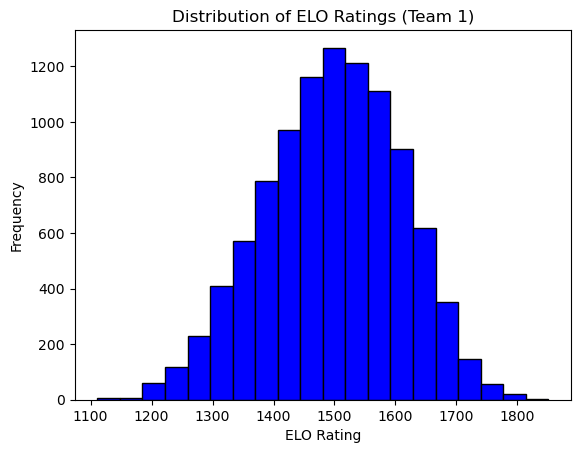

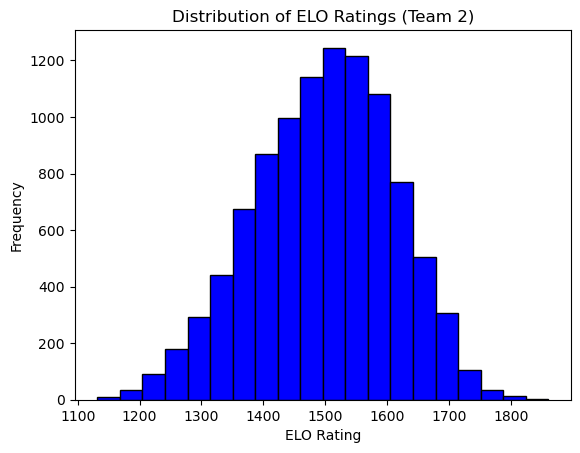

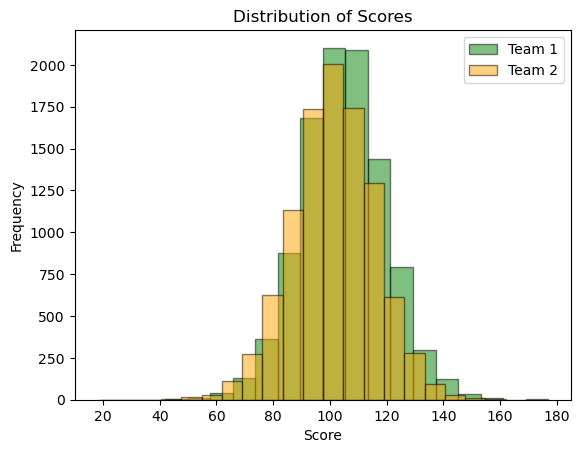

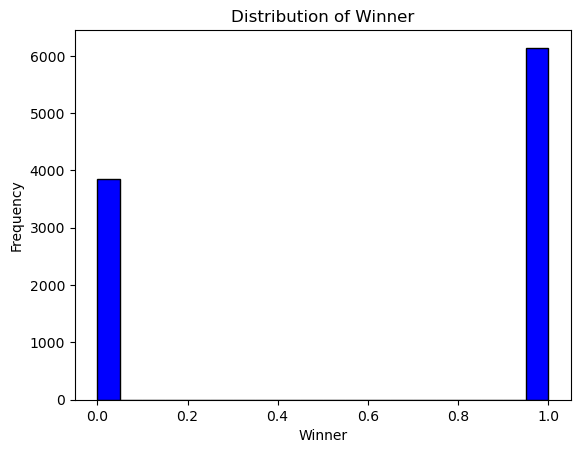

In [28]:
# Distribution of ELO ratings
plt.hist(small_train.get_column('elo1_pre'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of ELO Ratings (Team 1)")
plt.xlabel("ELO Rating")
plt.ylabel("Frequency")
plt.show()

# Distribution of ELO ratings
plt.hist(small_train.get_column('elo2_pre'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of ELO Ratings (Team 2)")
plt.xlabel("ELO Rating")
plt.ylabel("Frequency")
plt.show()

# Distribution of Scores
plt.hist(small_train.get_column('score1'), bins=20, alpha=0.5, label='Team 1', color='green', edgecolor='black')
plt.hist(small_train.get_column('score2'), bins=20, alpha=0.5, label='Team 2', color='orange', edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Distribution of Winner
plt.hist(small_train.get_column('winner'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of Winner")
plt.xlabel("Winner")
plt.ylabel("Frequency")
plt.show()


# Preliminary Classifications

## Define X_train, y_train, X_text, y_test
Since winner, the class we are predicting, is the last column, we can easily split the datasets into X_train, y_train, X_test, and y_test.

In [ ]:
# Define X_train, y_train, X_test, y_test
train_attributes = ['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'team1', 'team2', 'score1','score2' ]

attribute_indexes = [small_train.column_names.index(attr) for attr in train_attributes]

X_train = [[row[index] for index in attribute_indexes] for row in small_train.data]
y_train = [row[-1] for row in small_train.data]

X_test = [[row[index] for index in attribute_indexes] for row in test.data]
y_test = [row[-1] for row in test.data]


[[1488.6802, 1640.3429, 0.4261945652152269, 0.5738054347847731, 'GSW', 'DET', 113.0, 110.0], [1284.3158, 1552.9006, 0.2747903945829529, 0.7252096054170472, 'POR', 'LAL', 108.0, 128.0], [1465.6251, 1344.8678, 0.7808764420712828, 0.21912355792871718, 'WAS', 'MIL', 105.0, 97.0], [1447.4991, 1405.7803, 0.6933438554897465, 0.30665614451025347, 'NYK', 'PHI', 96.0, 106.0], [1447.448, 1480.2061, 0.5955784856015042, 0.40442151439849583, 'CHI', 'WAS', 87.0, 99.0], [1460.9286, 1396.2719, 0.7206806088192427, 0.2793193911807573, 'POR', 'GSW', 103.0, 98.0], [1495.7516, 1467.3317, 0.6768305983311735, 0.32316940166882646, 'CHI', 'IND', 102.0, 85.0], [1475.455, 1353.6281, 0.7819281537559897, 0.21807184624401033, 'MEM', 'NJN', 94.0, 101.0], [1443.2394, 1700.1228, 0.2884152084564301, 0.7115847915435699, 'CHI', 'MIL', 109.0, 107.0], [1587.1915, 1590.316, 0.6359109843126716, 0.36408901568732843, 'KEN', 'CAR', 99.0, 104.0], [1582.33975478041, 1456.72330136531, 0.7856249906519691, 0.2143750093480309, 'PHI', 

## Dummy Classifier

In [30]:
importlib.reload(mysklearn.myevaluation)
dummy = MyDummyClassifier()
myevaluation.evaluate_classifier(dummy, X_train, y_train, X_test, y_test, "Dummy Classifier")


=== Dummy Classifier ===
Evaluation results for Dummy Classifier:
Accuracy: 0.43
Error Rate: 0.57
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0, 620], [0, 460]]


## Naive Bayes Classifier

In [31]:
importlib.reload(mysklearn.myevaluation)
naive_bayes = MyNaiveBayesClassifier()
myevaluation.evaluate_classifier(naive_bayes, X_train, y_train, X_test, y_test, "Naive Bayes Classifier")




=== Naive Bayes Classifier ===
Evaluation results for Naive Bayes Classifier:
Accuracy: 0.65
Error Rate: 0.35
Precision: 0.62
Recall: 0.99
F1 Score: 0.76
Confusion Matrix:
[[615, 5], [374, 86]]


## Decision Trees Classifier

In [32]:
importlib.reload(mysklearn.myevaluation)
dt = MyDecisionTreeClassifier()
myevaluation.evaluate_classifier(dt, X_train, y_train, X_test, y_test, "Decision Tree Classifier")


=== Decision Tree Classifier ===
Evaluation results for Decision Tree Classifier:
Accuracy: 0.57
Error Rate: 0.43
Precision: 0.57
Recall: 1.00
F1 Score: 0.73
Confusion Matrix:
[[620, 0], [460, 0]]


## Random Forest Classifiers

In [33]:
importlib.reload(mysklearn.myevaluation)
random_forest = MyRandomForestClassifier(n=10, m=8, f=2, M=5, random_state=42)
myevaluation.evaluate_classifier(random_forest, X_train, y_train, X_test, y_test, "Random Forest Classifier")


=== Random Forest Classifier ===
Evaluation results for Random Forest Classifier:
Accuracy: 0.43
Error Rate: 0.57
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0, 620], [0, 460]]
